<a href="https://colab.research.google.com/github/sanatsingh/CNN/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer in PyTorch

In this notebook you can see how style from a certain image can be extracted and can be applied to the content of another image.

A 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers is used for feature and content extraction. The convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv_5_4.

<img src='https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg' width=60% />

Original paper : [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)
    
vgg.to('cuda')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Image Loading and conversion to tensor
image_load functions loads the image as a tensor for the model.  
image_show converts a copy of tensor and displays it as an image.

In [0]:
def image_load(imgpath, max_size=400):
    
    img = Image.open(imgpath).convert('RGB')
    
    if(max(img.size)>max_size):
        size = max_size
    else :
        size = max(img.size)
    
    #Resizing and converting image to tensor and normalising with mean=(0.485, 0.456, 0.406) and std=(0.229, 0.224, 0.225)
    
    input_transform = transforms.Compose([
                                            transforms.Resize(size),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406),
                                                                 (0.229, 0.224, 0.225))
                                         ])
    #Discarding the transparency layer at index no 3
    img = input_transform(img)[:3,:,:].unsqueeze(0)
    
    return img

In [0]:
def image_show(img):
    
    image = img.to("cpu").clone().detach() #Since the tensor was at gpu
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

In [0]:
style_img = image_load('/content/style.jpg',400).to('cuda')
content_img = image_load('/content.jpeg',400).to('cuda')

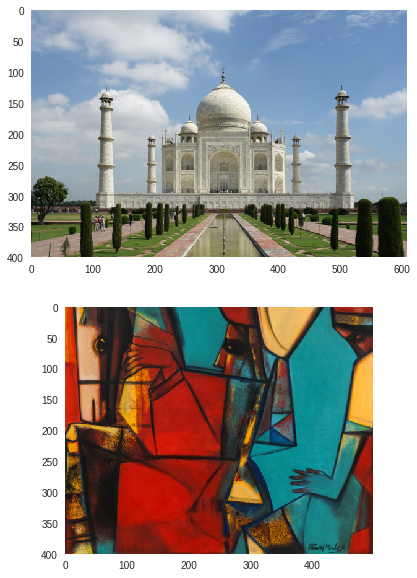

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.grid(False)
ax2.grid(False)
ax1.imshow(image_show(content_img))
ax2.imshow(image_show(style_img))

## Features Extraction, Gram Matrix functions
Gram matrix is used as a measurement of style.

In [0]:
def get_features(img,model,req_layers=None):
    if req_layers is None:
        #Mapping the layer numbers to their respective names 
        req_layers = {'0': 'conv1_1',
                      '5': 'conv2_1', 
                      '10': 'conv3_1', 
                      '19': 'conv4_1',
                      '21': 'conv4_2',
                      '28': 'conv5_1'
                     }
    features={}
    t = img
    #model._modules is dictionary which stores the name and the layer, 
    # names are in 0-36 hence denoted by idx
    for idx,layer in model._modules.items():
        
        t=layer(t) #Passing through layers
        
        if idx in req_layers: 
            #If we need the layer it is stored as layer's_name:layer's_output
            features[req_layers[idx]]=t
    
    return features
    

In [0]:
def gram_calc(x):
    _,d,h,w = x.size()   #Since 4D tensor, we only need depth,height and width of layer
    x = x.view(d,h*w)    #Flattening tensor to 2D matrix
    x = torch.mm(x,x.t()) #Matrix multiplied with it's transpose  
    return x

In [0]:
content_features = get_features(content_img,vgg) # Layer for content
style_features = get_features(style_img,vgg)

style_grams = {layer : gram_calc(style_features[layer]) for layer in style_features}

target = content_img.clone().requires_grad_(True).to('cuda') #Copy of content on which style will be applied

In [0]:
#Weights declaration for Loss calculation

content_weight = 1 #alpha
style_weight = 100. #beta
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.48,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

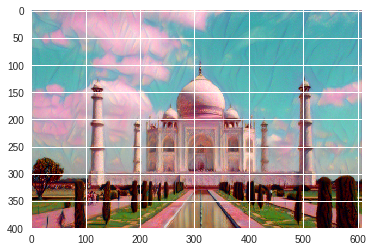

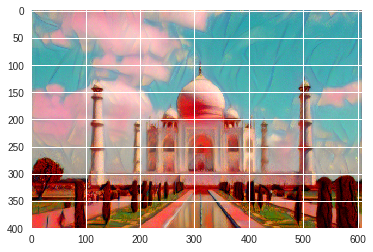

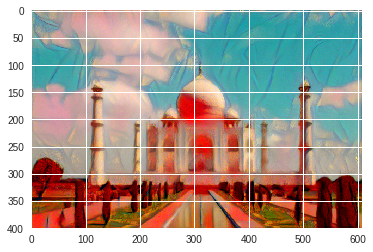

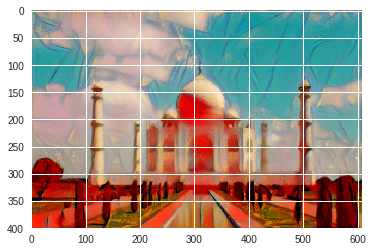

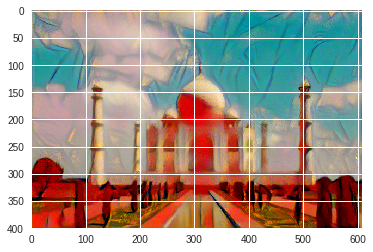

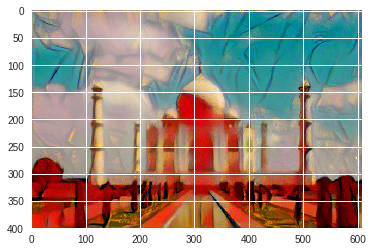

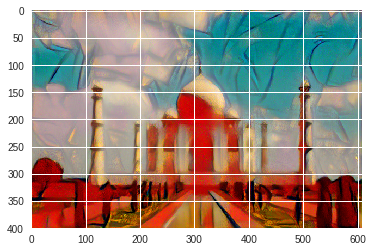

In [16]:
optimizer = optim.Adam([target],lr=0.003)

epochs = 3000

for idx in range(1,epochs+1):
    target_features = get_features(target,vgg)
    
    content_loss = torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
    
    style_loss=0
    
    for layer in style_weights:
        target_f = target_features[layer]
        _,d,h,w = target_f.size()
        target_gram = gram_calc(target_f)
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_grams[layer])**2)
        
        style_loss += layer_loss/(d*h*w)
    
    total_loss = content_loss * content_weight + style_loss * style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if idx%400==0 :
        plt.imshow(image_show(target))
        plt.show()

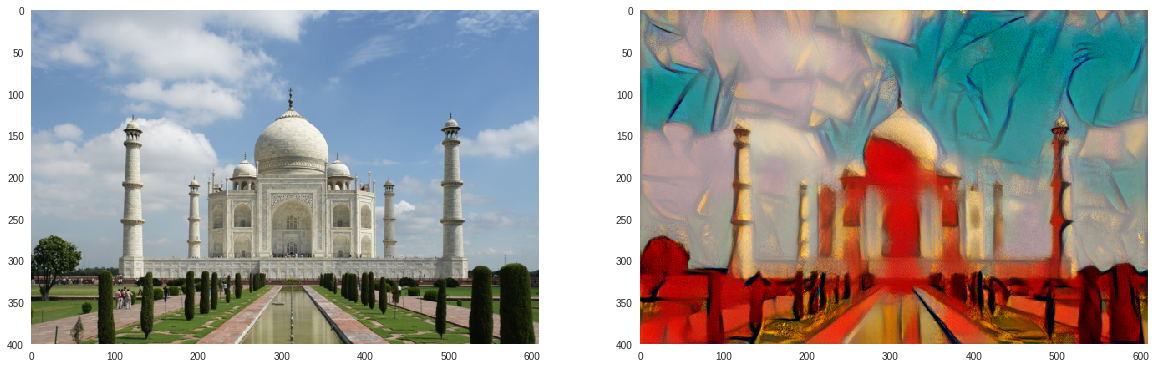

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.grid(False)
ax2.grid(False)
ax1.imshow(image_show(content_img))
ax2.imshow(image_show(target))